In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
from scipy.stats import dirichlet
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis,integral,integral_Lmin_Lmax
from jax import random, vmap
from jax.scipy.stats import norm
import numpyro.distributions as dist
from jax.scipy.special import gammaln
from astropy.cosmology import WMAP9 as cosmo
from scipy.optimize import curve_fit, brentq
import fitting
from scipy.optimize import minimize

2024-11-04 02:47:46.407036: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
#k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [4]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]

In [5]:
d_desi = Planck18.distmod(z_desi).value

In [6]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [7]:
# Assuming z_desi is your redshift array
filter_mask = (z_desi > 2.3) & (z_desi < 2.4)

# Apply the filter to all arrays
TARGETID = TARGETID[filter_mask]
#apr_mag_g = apr_mag_g[filter_mask]
#apr_mag_g_err = apr_mag_g_err[filter_mask]
apr_mag_r = apr_mag_r[filter_mask]
apr_mag_r_err = apr_mag_r_err[filter_mask]
d_desi = d_desi[filter_mask]
z_desi = z_desi[filter_mask]
#k_gg = k_gg[filter_mask]
k_rr = k_rr[filter_mask]

# Recalculate N_obs after filtering
N_obs = TARGETID.shape[0]
print(N_obs)

42124


In [8]:
apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d_desi = d_desi.astype(np.float64)
z_desi = z_desi.astype(np.float64)

In [9]:
def eff(m,b,m0):
    eff = jnp.where(m < m0, 1, 10**(-b*(m-m0)/2.5))
    return eff

ln_posterior = fitting.ln_posterior(eff)

def neg_likelihood(params,apr_mag,k,mu,apr_mag_err):
    m0,b,x = params
    log_likelihood = ln_posterior(m0, b, x, apr_mag, k, mu, apr_mag_err)
    #log_likelihood = ln_posterior(m0, b, x, apr_mag, k, mu, apr_mag_err,0.07977749883319056)
    return -log_likelihood

In [14]:
initial_guess = [18,0.5,1.85]
bounds = [(0,20),(0,1),(0,3)]

result = minimize(
    neg_likelihood, 
    initial_guess, 
    args=(apr_mag_r, k_rr, d_desi, apr_mag_r_err), 
    method='L-BFGS-B',
    bounds=bounds
)

optimal_params = result.x
optimal_likelihood = -result.fun  

print(f"Optimal parameters: m0 = {optimal_params[0]}, b = {optimal_params[1]}, x = {optimal_params[2]}")
print(f"Maximum likelihood value: {optimal_likelihood}")

first term -61307.06723835925
Poisson term 406399.9256968361
N_obs 40603.101213751565
first term -61307.067238361866
Poisson term 406399.92570382246
N_obs 40603.101400263724
first term -61307.06723838961
Poisson term 406399.92564903677
N_obs 40603.099937664054
first term -61307.06730886444
Poisson term 406399.9256850126
N_obs 40603.10089810188
first term -58895.19779796658
Poisson term -10487.287715201266
N_obs 568675.1332061259
first term -58895.19779796658
Poisson term -10487.287715201266
N_obs 568675.1332061259
first term -58895.1977980119
Poisson term -10487.280417338014
N_obs 568675.1253244348
first term -58895.197780289745
Poisson term -10487.285266704741
N_obs 568675.13056175
first term -61043.9131531695
Poisson term 406386.8475665007
N_obs 44014.95232572286
first term -61043.91315316975
Poisson term 406386.84755799663
N_obs 44014.95252366931
first term -61043.913153201705
Poisson term 406386.84762507625
N_obs 44014.95096228279
first term -61043.913220124596
Poisson term 406386.

In [11]:
'''
params = [16.0259,0.45,1.85]
neg_likelihood(params,apr_mag_r,k_rr,d_desi,apr_mag_r_err)
'''

'\nparams = [16.0259,0.45,1.85]\nneg_likelihood(params,apr_mag_r,k_rr,d_desi,apr_mag_r_err)\n'

  0%|          | 0/10 [00:00<?, ?it/s]

first term -65230.53561968019
Poisson term -428947.83369803394
N_obs 1011389.4583992811
first term -65238.885615129235
Poisson term -170463.07057747315
N_obs 739728.4242916026
first term -65248.822814121384
Poisson term -105705.4024827265
N_obs 670853.9044004922
first term -65260.07551556732
Poisson term -77117.01863227377
N_obs 640302.064267003
first term -65272.42154282258
Poisson term -61027.3683260344
N_obs 623062.7305535305
first term -65285.688893586834
Poisson term -50711.40936829429
N_obs 611991.5411837909
first term -65299.75605444235
Poisson term -43534.465642167954
N_obs 604280.4640324665
first term -65314.55206622639
Poisson term -38253.11688104062
N_obs 598601.3563109654
first term -65330.05645780962
Poisson term -34204.021780597395
N_obs 594244.5483826369


 10%|█         | 1/10 [00:06<00:57,  6.34s/it]

first term -65346.29911629672
Poisson term -31000.99507003196
N_obs 590796.3807313611
first term -64583.972722670835
Poisson term -57891.00597415108
N_obs 619698.2888072161
first term -64592.322649213485
Poisson term 106322.85284727259
N_obs 441170.65449861117
first term -64602.259779348984
Poisson term 147019.3100364448
N_obs 395915.0255505679
first term -64613.51241200802
Poisson term 164899.99741312576
N_obs 375842.6692848998
first term -64625.858370564696
Poisson term 174936.24781129463
N_obs 364517.60218849406
first term -64639.12565273578
Poisson term 181359.82131631905
N_obs 357245.1165867123
first term -64653.19274511935
Poisson term 185823.30426441762
N_obs 352180.1294021512
first term -64667.98868856729
Poisson term 189104.88805642864
N_obs 348450.0091857669
first term -64683.4930119638
Poisson term 191619.0360580249
N_obs 345588.50696784543


 20%|██        | 2/10 [00:12<00:48,  6.12s/it]

first term -64699.73560242635
Poisson term 193606.73167671874
N_obs 343323.8642100244
first term -63586.99740449668
Poisson term 176745.8676168648
N_obs 362470.7834945119
first term -63595.346741079265
Poisson term 277509.37516009505
N_obs 245251.0514219046
first term -63605.28328168052
Poisson term 301753.3619616629
N_obs 215573.98649592715
first term -63616.53532540257
Poisson term 312251.32974004326
N_obs 202424.94474239746
first term -63628.880695778316
Poisson term 318092.6921822173
N_obs 195012.02137897362
first term -63642.14739067113
Poisson term 321809.64409036323
N_obs 190254.71517206833
first term -63656.213896814384
Poisson term 324381.5900177277
N_obs 186943.0914420897
first term -63671.00925518503
Poisson term 326266.51793778455
N_obs 184505.22416983833
first term -63686.512994783625
Poisson term 327707.05423097615
N_obs 182635.67865859473


 30%|███       | 3/10 [00:18<00:43,  6.21s/it]

first term -63702.75500283669
Poisson term 328843.67570078885
N_obs 181156.5039242239
first term -62072.42154768429
Poisson term 318444.66756484937
N_obs 194562.92637092227
first term -62080.76584838708
Poisson term 373840.13944275974
N_obs 118159.28772194317
first term -62090.697356738354
Poisson term 385537.1227832951
N_obs 99017.38628074773
first term -62101.94437330682
Poisson term 390207.20577134436
N_obs 90609.26007461824
first term -62114.284722983444
Poisson term 392668.01440249605
N_obs 85900.36219706075
first term -62127.54640488579
Poisson term 394173.74247557006
N_obs 82893.90110845762
first term -62141.60790690426
Poisson term 395185.3212416674
N_obs 80809.60910841207
first term -62156.39827108558
Poisson term 395909.7846312774
N_obs 79280.33365082432
first term -62171.89702742537
Poisson term 396453.2907209421
N_obs 78110.77935497423


 40%|████      | 4/10 [00:24<00:36,  6.11s/it]

first term -62188.13406408299
Poisson term 396875.6649778726
N_obs 77187.56158053872
first term -59981.410819656165
Poisson term 390746.4744945582
N_obs 89596.5205252755
first term -59989.71302636919
Poisson term 406427.824238994
N_obs 42265.46223372838
first term -59999.602470805214
Poisson term 404722.8982210917
N_obs 31247.099814802827
first term -60010.80746597
Poisson term 402640.28338575055
N_obs 26691.057902164295
first term -60023.105848269435
Poisson term 401043.9006856816
N_obs 24253.739422107392
first term -60036.32562745258
Poisson term 399852.7948653124
N_obs 22751.56106278811
first term -60050.34530121487
Poisson term 398947.39083588275
N_obs 21738.751550915986
first term -60065.0939206663
Poisson term 398241.9830800124
N_obs 21012.17174318287
first term -60080.55102423059
Poisson term 397679.4980765103
N_obs 20466.717247414846


 50%|█████     | 5/10 [00:31<00:31,  6.24s/it]

first term -60096.74650796705
Poisson term 397221.7677634062
N_obs 20042.80822229671
first term -58159.397357917005
Poisson term 405592.72160972096
N_obs 34282.38047230602
first term -58167.37478648737
Poisson term 377317.29855779815
N_obs 9797.556633945778
first term -58176.93968793807
Poisson term 357216.05307457875
N_obs 5488.444678517947
first term -58187.820477472975
Poisson term 345957.4994251314
N_obs 4061.257176253608
first term -58199.79508610524
Poisson term 339221.599667943
N_obs 3407.8240543955267
first term -58212.69161088408
Poisson term 334863.99937629385
N_obs 3046.6838690547747
first term -58226.38862994492
Poisson term 331853.60673829535
N_obs 2821.4223537286102
first term -58240.81526866715
Poisson term 329663.17985409277
N_obs 2668.770190727637
first term -58255.95113445947
Poisson term 328003.2255115395
N_obs 2558.9698785075843


 60%|██████    | 6/10 [00:36<00:24,  6.12s/it]

first term -58271.82618797791
Poisson term 326704.1154882811
N_obs 2476.396295727868
first term -60169.130059298586
Poisson term 382488.22559494333
N_obs 11546.889578282313
first term -60174.94288394478
Poisson term 310839.7762685655
N_obs 1666.91966872503
first term -60182.34490733678
Poisson term 270493.1752100138
N_obs 624.011684591035
first term -60191.065364923066
Poisson term 250986.71225283993
N_obs 390.54937508063944
first term -60200.88295342183
Poisson term 240797.26055070292
N_obs 306.02167290266334
first term -60211.62648142021
Poisson term 234794.20446223384
N_obs 265.1181921959525
first term -60223.1751863741
Poisson term 230885.73869953182
N_obs 241.49048039207085
first term -60235.45880501259
Poisson term 228147.51383757367
N_obs 226.20991324954562
first term -60248.45751423437
Poisson term 226123.9501746194
N_obs 215.54548626438577


 70%|███████   | 7/10 [00:43<00:18,  6.26s/it]

first term -60262.20180869766
Poisson term 224567.68477529215
N_obs 207.68875384283714
first term -72315.53241600838
Poisson term 339546.283464244
N_obs 3436.5337874157826
first term -72310.0197917092
Poisson term 231126.70860562447
N_obs 242.88391732181702
first term -72306.10567542804
Poisson term 170991.4402520136
N_obs 58.01011962100753
first term -72303.52513367016
Poisson term 145730.49938672176
N_obs 31.827013542482007
first term -72302.06240262058
Poisson term 134119.27405156734
N_obs 24.15495031397817
first term -72301.55152765181
Poisson term 127678.21141587343
N_obs 20.728318334181324
first term -72301.87668127271
Poisson term 123590.28336295582
N_obs 18.810404817159032
first term -72302.97224956121
Poisson term 120760.02943900075
N_obs 17.587571772999503
first term -72304.82279910345
Poisson term 118681.46410542348
N_obs 16.74045800716036


 80%|████████  | 8/10 [00:49<00:12,  6.16s/it]

first term -72307.46297947955
Poisson term 117088.78518307942
N_obs 16.119091462026475
first term -95614.53719588311
Poisson term 280392.86141963024
N_obs 792.4914158822842
first term -95572.31519112925
Poisson term 144698.0049052226
N_obs 31.055821147012498
first term -95531.68590321588
Poisson term 67041.19979243237
N_obs 4.911782308164203
first term -95492.41260937059
Poisson term 38225.91563398978
N_obs 2.478170301494557
first term -95454.30687205933
Poisson term 26168.89911309575
N_obs 1.861307300901902
first term -95417.22904757474
Poisson term 19647.170174714076
N_obs 1.5943252187273096
first term -95381.08852400677
Poisson term 15534.178831865294
N_obs 1.446008454958796
first term -95345.84378721064
Poisson term 12692.519790155106
N_obs 1.3516760604355431
first term -95311.50240328035
Poisson term 10607.491324593031
N_obs 1.2863984303762817


 90%|█████████ | 9/10 [00:55<00:06,  6.08s/it]

first term -95278.12093348386
Poisson term 9010.648308616006
N_obs 1.23854476119726
first term -114144.29566160036
Poisson term 197520.4501079122
N_obs 109.02883159673709
first term -114055.53940836954
Poisson term 48446.68343163182
N_obs 3.158735928598245
first term -113968.12877797429
Poisson term -39332.65480120436
N_obs 0.3930864535234915
first term -113881.87562434943
Poisson term -69786.60193218615
N_obs 0.19076937560792984
first term -113796.64060870445
Poisson term -81955.31412993404
N_obs 0.1429058098487599
first term -113712.33330765471
Poisson term -88489.15071302236
N_obs 0.1223732326109247
first term -113628.91214586137
Poisson term -92605.20145891952
N_obs 0.11098140501088816
first term -113546.38425820596
Poisson term -95448.17526209466
N_obs 0.10373835360473813
first term -113464.80531740564
Poisson term -97533.93447443032
N_obs 0.09872685851802843


100%|██████████| 10/10 [01:02<00:00,  6.20s/it]

first term -113384.27927981381
Poisson term -99131.24374384567
N_obs 0.09505329401094012


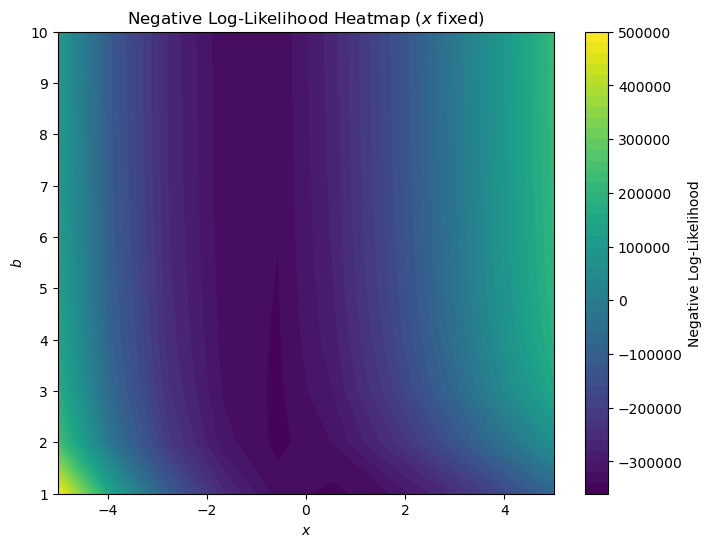

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the parameter grid for m0 and b
x_values = np.linspace(-5, 5, 10)
#m0_values = np.linspace(1.5, 2.5, 10)
b_values = np.linspace(1, 10, 10)

# Calculate likelihoods for a fixed x
#x_fixed = 1.7
m0_fixed = 18
#b_fixed = 0.5
likelihoods = np.zeros((len(x_values), len(b_values)))

for i, x in enumerate(tqdm(x_values)):
    for j, b in enumerate(b_values):
        params = [m0_fixed, b, x]
        likelihoods[i, j] = neg_likelihood(params,apr_mag_r, k_rr, d_desi, apr_mag_r_err)

# Create a heatmap
plt.figure(figsize=(8, 6))
plt.contourf(x_values, b_values, likelihoods.T, levels=50, cmap='viridis')
plt.colorbar(label='Negative Log-Likelihood')
plt.xlabel('$x$')
plt.ylabel('$b$')
plt.title('Negative Log-Likelihood Heatmap ($x$ fixed)')
plt.show()

In [13]:
params = [18.358572258469366,0.5762614390624853,1.85]
neg_likelihood(params,apr_mag_r, k_rr, d_desi, apr_mag_r_err)

first term -61307.30133250762
Poisson term 406282.5788698922
N_obs 38719.366488890126


Array(-344975.27753738, dtype=float64)